# GPU Accelerated Computing - Assignment 2

Muhammad Meesum Ali Qazalbash (mq06861)

In [2]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-g8os174_
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-g8os174_
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit aac710a35f52bb78ab34d2e52517237941399eff
  Preparing metadata (setup.py) ... done
directory /content/src already exists
Out bin /content/result.out


In [2]:
!apt-get install gcc

Reading package lists... Done
Building dependency tree       
Reading state information... Done
gcc is already the newest version (4:9.3.0-1ubuntu2).
gcc set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.


# Question 1

## Part a

Implement the code on the CPU in Google colab environment showing results of the circular pattern image (Fig 8(c) in [1]). Give comparison of your code output against fig 9(a) and fig 11(c). The figures are copied in figure 1 and 2 respectively. Use any timing function like `clock()` or hiresolution counters to note the amount of time it takes to process image data on the CPU. (+30)

In [27]:
%%writefile demo.c

#include <math.h>
#include <stdint.h>
#include <stdio.h>
#include <stdlib.h>
#include <time.h>

#define PI ((double)3.14159265358979323846264338327950288419716939937510)

/**
 * @brief Nearest neighbour interpolation
 *
 * @param src
 * @param dst
 * @param w
 * @param h
 * @param theta
 */
void rotate_nearest_neighbour(const uint8_t *const src, uint8_t *dst, const long w, const long h, const double theta) {
    const double c  = cos(theta);
    const double s  = sin(theta);
    const double cx = (w - 1) / 2.0;
    const double cy = (h - 1) / 2.0;
    double       dx, dy;
    long         Rxf, Ryf, x, y;
    for (y = 0; y < h; y++) {
        for (x = 0; x < w; x++) {
            dx  = x - cx;
            dy  = y - cy;
            Rxf = (long)floor(dx * c - dy * s + cx + 0.5);
            Ryf = (long)floor(dx * s + dy * c + cy + 0.5);

            dst[y * w + x] = (0 <= Rxf && Rxf < w && 0 <= Ryf && Ryf < h) ? src[Ryf * w + Rxf] : 0;
        }
    }
}

/**
 * @brief Bilinear interpolation
 *
 * @param src
 * @param dst
 * @param w
 * @param h
 * @param theta
 */
void rotate_bilinear(const uint8_t *const src, uint8_t *dst, const long w, const long h, const double theta) {
    const double c  = cos(theta);
    const double s  = sin(theta);
    const double cx = (w - 1) / 2.0;
    const double cy = (h - 1) / 2.0;
    double       dx, dy, Rx, Ry, dRx, dRy;
    long         Rxf, Ryf, y, x;
    for (y = 0; y < h; y++) {
        for (x = 0; x < w; x++) {
            dx  = x - cx;
            dy  = y - cy;
            Rx  = dx * c - dy * s + cx;
            Ry  = dx * s + dy * c + cy;
            Rxf = (long)floor(Rx + 0.5);
            Ryf = (long)floor(Ry + 0.5);

            dRx = Rx - Rxf;
            dRy = Ry - Ryf;

            if (0 <= Rxf && Rxf + 1 < w && 0 <= Ryf && Ryf + 1 < h) {
                dst[y * w + x] = (1 - dRx) * (1 - dRy) * src[Ryf * w + Rxf] + dRx * (1 - dRy) * src[Ryf * w + Rxf + 1] +
                                 (1 - dRx) * dRy * src[(Ryf + 1) * w + Rxf] + dRx * dRy * src[(Ryf + 1) * w + Rxf + 1];
            } else {
                dst[y * w + x] = 0;
            }
        }
    }
}

/**
 * @brief Bicubic interpolation
 *
 * @param c
 * @param x
 * @return double
 */
double interpolate(const double *const c, const double x) {
    return c[1] + 0.5 * x *
                      (c[2] - c[0] +
                       x * (2.0 * c[0] - 5.0 * c[1] + 4.0 * c[2] - c[3] + x * (3.0 * (c[1] - c[2]) + c[3] - c[0])));
}

/**
 * @brief Bicubic interpolation using 4x4 matrix
 *
 * @param p
 * @param u
 * @param v
 * @return double
 */
double bicubic_interpolate(const double p[4][4], const double u, const double v) {
    double px[4], py[4];
    for (int i = 0; i < 4; i++) {
        px[i] = interpolate(p[i], u);
        py[i] = interpolate(&p[0][i], v);
    }
    return interpolate(px, v);
}

/**
 * @brief Bicubic interpolation
 *
 * @param src
 * @param dst
 * @param w
 * @param h
 * @param theta
 */
void rotate_bicubic(const uint8_t *const src, uint8_t *dst, const long w, const long h, const double theta) {
    const double c  = cos(theta);
    const double s  = sin(theta);
    const double cx = (w - 1) / 2.0;
    const double cy = (h - 1) / 2.0;

    double dx, dy, Rx, Ry, dRx, dRy, interpolated_value;
    long   Rxf, Ryf, y, x;

    double p[4][4];

    for (y = 0; y < h; y++) {
        for (x = 0; x < w; x++) {
            dx = x - cx;
            dy = y - cy;
            Rx = dx * c - dy * s + cx;
            Ry = dx * s + dy * c + cy;
            if (0 <= Rx && Rx + 1 < w && 0 <= Ry && Ry + 1 < h) {
                Rxf = (int)floor(Rx + 0.5);
                Ryf = (int)floor(Ry + 0.5);

                dRx = Rx - Rxf;
                dRy = Ry - Ryf;

                for (uint8_t m = 0; m < 4; m++) {
                    for (uint8_t n = 0; n < 4; n++) {
                        int xidx = Rxf + n - 1;
                        int yidx = Ryf + m - 1;

                        p[m][n] = xidx >= 0 && xidx < w && yidx >= 0 && yidx < h ? src[yidx * w + xidx] : 0;
                    }
                }

                interpolated_value = bicubic_interpolate(p, dRx, dRy);

                dst[y * w + x] =
                    interpolated_value > 255.0 || interpolated_value < 0.0 ? 0 : (uint8_t)round(interpolated_value);
            } else
                dst[y * w + x] = 0;
        }
    }
}

/**
 * @brief Read the image
 *
 * @param filename
 * @param img
 * @param w
 * @param h
 */
void read_image(char *filename, uint8_t *img, const long w, const long h) {
    FILE *fp = fopen(filename, "rb");
    if (fp == NULL) {
        fprintf(stderr, "cannot open %s for reading\n", filename);
        exit(1);
    }
    for (long i = 0UL; i < w * h; i++) {
        unsigned char c;
        fread(&c, sizeof(unsigned char), 1, fp);
        img[i] = (double)c;
    }
    fclose(fp);
}

/**
 * @brief Write the image
 *
 * @param filename
 * @param img
 * @param w
 * @param h
 */
void write_image(char *filename, uint8_t *img, const long w, const long h) {
    FILE *fp = fopen(filename, "wb");
    if (fp == NULL) {
        fprintf(stderr, "cannot open %s for writing\n", filename);
        exit(1);
    }
    for (long i = 0UL; i < w * h; i++) {
        unsigned char c = (unsigned char)img[i];
        fwrite(&c, sizeof(unsigned char), 1, fp);
    }
    fclose(fp);
}

/**
 * @brief Rotate the image according to the given interpolation method
 *
 * @param src
 * @param dst
 * @param method
 * @param width
 * @param height
 * @param theta
 */
void rotate_interpolate_image(const uint8_t *const src, uint8_t *dst, const uint8_t method, const long width,
                              const long height, const double theta) {
    switch (method) {
        case 0:
            rotate_nearest_neighbour(src, dst, width, height, theta);
            break;
        case 1:
            rotate_bilinear(src, dst, width, height, theta);
            break;
        case 2:
            rotate_bicubic(src, dst, width, height, theta);
            break;
        default:
            fprintf(stderr, "unknown method: %d\n", method);
            exit(1);
    }
}

/**
 * @brief Main function
 *
 * @param argc
 * @param argv
 * @return int
 */
int main(int argc, char *argv[]) {
    if (argc != 7) {
        fprintf(stderr, "usage: %s <input> <output> <width> <height> <method> <theta>\n", argv[0]);
        exit(1);
    }

    const int     w      = atoi(argv[3]);
    const int     h      = atoi(argv[4]);
    const uint8_t method = atoi(argv[5]);
    const double  theta  = atof(argv[6]) * PI / 180.0;
    uint8_t      *src    = (uint8_t *)malloc(sizeof(uint8_t) * w * h);
    uint8_t      *dst    = (uint8_t *)malloc(sizeof(uint8_t) * w * h);
    uint8_t      *tmp;

    read_image(argv[1], src, w, h);

    clock_t start = clock(), end;

    for (int i = 0; i < 4; i++) {
        rotate_interpolate_image(src, dst, method, w, h, theta);
        tmp = src;
        src = dst;
        dst = tmp;
    }

    end = clock();

    printf("%f ms\n", (double)(end - start) / (CLOCKS_PER_SEC * 4));

    write_image(argv[2], dst, w, h);

    free(src);
    free(dst);
    return 0;
}


Overwriting demo.c


In [29]:
! gcc demo.c -Wall -Wextra -o demo2.o -lm
! ./demo2.o ../content/lena.img ../content/lena_out.img 256 256 2 15

demo.c: In function ‘bicubic_interpolate’:
demo.c:98:19: warning: variable ‘py’ set but not used [-Wunused-but-set-variable]
   98 |     double px[4], py[4];
      |                   ^~
0.012538 ms


## Part b

Implement the code on the GPU in Google Colab environment showing results of the circular pattern image (Fig 8(c) in [1]). Give comparison of your code output against fig 9(a) and fig 11(c). The figures are given below for your reference again. Note the time it takes to run the kernel using the CUDA event API to calculate the amount of time needed by the GPU. (+30)

In [7]:
%%cu

#include <stdint.h>
#include <stdio.h>
#include <stdlib.h>
#include <time.h>

#define PI ((double)3.14159265358979323846264338327950288419716939937510)

const long   LENGTH   = 256L;
const double ROTATION = 15 * PI / 180.0;
const long   REPEAT   = 24L;

/**
 * @brief Check for CUDA errors
 *
 * @param err
 * @param msg
 * @return cudaError_t
 */
inline cudaError_t checkCudaErr(cudaError_t err, const char *msg) {
    if (err != cudaSuccess) fprintf(stderr, "CUDA Runtime error at %s: %s\n", msg, cudaGetErrorString(err));
    return err;
}

/**
 * @brief Rotate an image using nearest neighbour interpolation
 *
 * @param src
 * @param dst
 * @param w
 * @param theta
 * @return __global__
 */
__global__ void rotate_nearest_neighbour(const uint8_t *src, uint8_t *dst, const long w, const double theta) {
    const long x = threadIdx.x + blockIdx.x * blockDim.x;  // x value of the thread
    const long y = threadIdx.y + blockIdx.y * blockDim.y;  // y value of the thread

    if (x < w && y < w) {              // check if the thread is inside the image boundaries
        const double c = cosf(theta);  // cosine of the rotation angle
        const double s = sinf(theta);  // sine of the rotation angle

        const double co = (w - 1L) / 2.0;  // center of the image

        const double dx = x - co;  // x coordinate of the pixel in the rotated image
        const double dy = y - co;  // y coordinate of the pixel in the rotated image

        const long Rxf = (long)(dx * c - dy * s + co + 0.5);  // x coordinate of the pixel in the original image
        const long Ryf = (long)(dx * s + dy * c + co + 0.5);  // y coordinate of the pixel in the original image

        dst[y * w + x] = (0L <= Rxf && Rxf < w && 0L <= Ryf && Ryf < w) ? src[Ryf * w + Rxf] : 0;  // copy the pixel
    }
}

/**
 * @brief Rotate an image using bilinear interpolation
 *
 * @param src
 * @param dst
 * @param w
 * @param theta
 * @return __global__
 */
__global__ void rotate_bilinear(const uint8_t *src, uint8_t *dst, const long w, const double theta) {
    const long x = threadIdx.x + blockIdx.x * blockDim.x;  // x value of the thread
    const long y = threadIdx.y + blockIdx.y * blockDim.y;  // y value of the thread

    if (x < w && y < w) {              // check if the thread is inside the image boundaries
        const double c = cosf(theta);  // cosine of the rotation angle
        const double s = sinf(theta);  // sine of the rotation angle

        const double co = (w - 1L) / 2.0;  // center of the image

        const double dx = x - co;  // x coordinate of the pixel in the rotated image
        const double dy = y - co;  // y coordinate of the pixel in the rotated image

        const double Rx = dx * c - dy * s + co;  // x coordinate of the pixel in the original image
        const double Ry = dx * s + dy * c + co;  // y coordinate of the pixel in the original image

        const long Rxf = (long)floor(Rx + 0.5);  // x coordinate of the pixel in the original image
        const long Ryf = (long)floor(Ry + 0.5);  // y coordinate of the pixel in the original image

        const double dRx = Rx - Rxf;  // distance between the pixel and the left pixel
        const double dRy = Ry - Ryf;  // distance between the pixel and the top pixel

        if (0L <= Rxf && Rxf + 1L < w && 0L <= Ryf &&
            Ryf + 1L < w)  // check if the pixel is inside the image boundaries
            dst[y * w + x] = (1.0 - dRx) * (1.0 - dRy) * src[Ryf * w + Rxf] +
                             dRx * (1.0 - dRy) * src[Ryf * w + Rxf + 1L] +
                             (1.0 - dRx) * dRy * src[(Ryf + 1L) * w + Rxf] +
                             dRx * dRy * src[(Ryf + 1L) * w + Rxf + 1L];  // copy the pixel
        else
            dst[y * w + x] = 0;  // copy the pixel
    }
}

/**
 * @brief Bicubic interpolation
 *
 * @param c
 * @param x
 * @return double
 */
__device__ double interpolate(const double *const c, const double x) {
    return c[1] + 0.5 * x *
                      (c[2] - c[0] +
                       x * (2.0 * c[0] - 5.0 * c[1] + 4.0 * c[2] - c[3] + x * (3.0 * (c[1] - c[2]) + c[3] - c[0])));
}

/**
 * @brief Bicubic interpolation using 4x4 matrix
 *
 * @param p
 * @param u
 * @param v
 * @return double
 */
__device__ double bicubic_interpolate(const double p[4][4], const double u, const double v) {
    double px[4], py[4];  // temporary arrays
    for (int i = 0; i < 4; i++) {
        px[i] = interpolate(p[i], u);      // interpolate in x direction
        py[i] = interpolate(&p[0][i], v);  // interpolate in y direction
    }
    return interpolate(px, v);  // interpolate in x direction
}

/**
 * @brief Bicubic interpolation
 *
 * @param src
 * @param dst
 * @param w
 * @param h
 * @param theta
 */
__global__ void rotate_bicubic(const uint8_t *const src, uint8_t *dst, const long w, const double theta) {
    const long x = threadIdx.x + blockIdx.x * blockDim.x;  // x value of the thread
    const long y = threadIdx.y + blockIdx.y * blockDim.y;  // y value of the thread

    if (x < w && y < w) {
        const double c  = cosf(theta);    // cosine of the rotation angle
        const double s  = sinf(theta);    // sine of the rotation angle
        const double co = (w - 1) / 2.0;  // center of the image

        double dx, dy, Rx, Ry, dRx, dRy, interpolated_value;  // temporary variables
        long   Rxf, Ryf, y, x;                                // temporary variables

        double p[4][4];  // 4x4 matrix

        for (y = 0; y < w; y++) {           // loop over the image
            for (x = 0; x < w; x++) {       // loop over the image
                dx = x - co;                // x coordinate of the pixel in the rotated image
                dy = y - co;                // y coordinate of the pixel in the rotated image
                Rx = dx * c - dy * s + co;  // x coordinate of the pixel in the original image
                Ry = dx * s + dy * c + co;  // y coordinate of the pixel in the original image
                if (0 <= Rx && Rx + 1 < w && 0 <= Ry &&
                    Ry + 1 < w) {  // check if the pixel is inside the image boundaries

                    Rxf = (long)floor(Rx + 0.5);  // x coordinate of the pixel in the original image
                    Ryf = (long)floor(Ry + 0.5);  // y coordinate of the pixel in the original image

                    dRx = Rx - Rxf;  // distance between the pixel and the left pixel
                    dRy = Ry - Ryf;  // distance between the pixel and the top pixel

                    for (uint8_t m = 0; m < 4; m++) {
                        for (uint8_t n = 0; n < 4; n++) {
                            int xidx = Rxf + n - 1;  // x coordinate of the pixel in the original image
                            int yidx = Ryf + m - 1;  // y coordinate of the pixel in the original image

                            p[m][n] = xidx >= 0 && xidx < w && yidx >= 0 && yidx < w ? src[yidx * w + xidx]
                                                                                     : 0;  // copy the pixel
                        }
                    }

                    interpolated_value = bicubic_interpolate(p, dRx, dRy);  // interpolate the pixel

                    dst[y * w + x] = interpolated_value > 255.0 || interpolated_value < 0.0
                                         ? 0
                                         : (uint8_t)round(interpolated_value);  // copy the pixel
                } else
                    dst[y * w + x] = 0;  // copy the pixel
            }
        }
    }
}

/**
 * @brief Read an image from a file
 *
 * @param filename
 * @param img
 * @param w
 * @param h
 */
void read_image(const char filename[], uint8_t *img, const long w, const long h) {
    FILE *fp = fopen(filename, "rb");
    if (fp == NULL) {
        fprintf(stderr, "cannot open %s for reading\n", filename);
        exit(1);
    }
    for (long i = 0L; i < w * h; i++) {
        unsigned char c;
        fread(&c, sizeof(unsigned char), 1, fp);
        img[i] = (double)c;
    }
    fclose(fp);
}

/**
 * @brief Write an image to a file
 *
 * @param filename
 * @param img
 * @param w
 * @param h
 */
void write_image(const char filename[], uint8_t *img, const long w, const long h) {
    FILE *fp = fopen(filename, "wb");
    if (fp == NULL) {
        fprintf(stderr, "cannot open %s for writing\n", filename);
        exit(1);
    }
    for (long i = 0L; i < w * h; i++) {
        unsigned char c = (unsigned char)img[i];
        fwrite(&c, sizeof(unsigned char), 1, fp);
    }
    fclose(fp);
}

/**
 * @brief Repeatedly rotate an image using nearest neighbour interpolation
 *
 * @param h_dst
 * @param d_src
 * @param d_dst
 * @param numBlocks
 * @param threadsPerBlock
 */
void repeated_nearest_neighbour(uint8_t *h_dst, uint8_t *d_src, uint8_t *d_dst, const dim3 numBlocks,
                                const dim3 threadsPerBlock) {
    float       gpu_time = 0.0f;      // time used on the GPU for all iterations
    cudaEvent_t start_gpu, stop_gpu;  // events for timing

    for (long i = 0L; i < REPEAT; i++) {  // repeat the operation REPEAT times
        float gpu_time_used = 0.0f;       // time used on the GPU for one iteration

        checkCudaErr(cudaEventCreate(&start_gpu), "cudaEventCreate");    // create the start event
        checkCudaErr(cudaEventCreate(&stop_gpu), "cudaEventCreate");     // create the stop event
        checkCudaErr(cudaEventRecord(start_gpu, 0), "cudaEventRecord");  // record the start event

        rotate_nearest_neighbour<<<numBlocks, threadsPerBlock>>>(d_src, d_dst, LENGTH, ROTATION);  // call the kernel
        checkCudaErr(cudaDeviceSynchronize(), "cudaDeviceSynchronize");  // wait for the kernel to finish

        checkCudaErr(cudaEventRecord(stop_gpu, 0), "cudaEventRecord");         // record the stop event
        checkCudaErr(cudaEventSynchronize(stop_gpu), "cudaEventSynchronize");  // wait for the stop event to be recorded
        checkCudaErr(cudaEventElapsedTime(&gpu_time_used, start_gpu, stop_gpu),
                     "cudaEventElapsedTime");  // compute the time used

        checkCudaErr(cudaMemcpy(h_dst, d_dst, sizeof(uint8_t) * LENGTH * LENGTH, cudaMemcpyDeviceToHost),
                     "cudaMemcpy");  // copy the result back to the host
        checkCudaErr(cudaMemcpy(d_src, h_dst, sizeof(uint8_t) * LENGTH * LENGTH, cudaMemcpyHostToDevice),
                     "cudaMemcpy");  // copy the result back to the device

        checkCudaErr(cudaEventDestroy(start_gpu), "cudaEventDestroy");  // destroy the events
        checkCudaErr(cudaEventDestroy(stop_gpu), "cudaEventDestroy");   // destroy the events

        gpu_time += gpu_time_used;  // add the time used for this iteration to the total time
    }
    checkCudaErr(cudaMemcpy(h_dst, d_dst, sizeof(uint8_t) * LENGTH * LENGTH, cudaMemcpyDeviceToHost),
                 "cudaMemcpy");  // copy the result back to the host

    printf("nearest neighbour: %f ms\n", gpu_time / REPEAT);  // print the average time used
}

/**
 * @brief Repeatedly rotate an image using bilinear interpolation
 *
 * @param h_dst
 * @param d_src
 * @param d_dst
 * @param numBlocks
 * @param threadsPerBlock
 */
void repeated_bilinear(uint8_t *h_dst, uint8_t *d_src, uint8_t *d_dst, const dim3 numBlocks,
                       const dim3 threadsPerBlock) {
    float       gpu_time;             // time used on the GPU for all iterations
    cudaEvent_t start_gpu, stop_gpu;  // events for timing

    for (long i = 0L; i < REPEAT; i++) {  // repeat the operation REPEAT times
        float gpu_time_used = 0.0f;       // time used on the GPU for one iteration

        checkCudaErr(cudaEventCreate(&start_gpu), "cudaEventCreate");    // create the start event
        checkCudaErr(cudaEventCreate(&stop_gpu), "cudaEventCreate");     // create the stop event
        checkCudaErr(cudaEventRecord(start_gpu, 0), "cudaEventRecord");  // record the start event

        rotate_bilinear<<<numBlocks, threadsPerBlock>>>(d_src, d_dst, LENGTH, ROTATION);  // call the kernel

        checkCudaErr(cudaDeviceSynchronize(), "cudaDeviceSynchronize");  // wait for the kernel to finish

        checkCudaErr(cudaEventRecord(stop_gpu, 0), "cudaEventRecord");         // record the stop event
        checkCudaErr(cudaEventSynchronize(stop_gpu), "cudaEventSynchronize");  // wait for the stop event to be recorded
        checkCudaErr(cudaEventElapsedTime(&gpu_time_used, start_gpu, stop_gpu),
                     "cudaEventElapsedTime");  // compute the time used

        checkCudaErr(cudaMemcpy(h_dst, d_dst, sizeof(uint8_t) * LENGTH * LENGTH, cudaMemcpyDeviceToHost),
                     "cudaMemcpy");  // copy the result back to the host
        checkCudaErr(cudaMemcpy(d_src, h_dst, sizeof(uint8_t) * LENGTH * LENGTH, cudaMemcpyHostToDevice),
                     "cudaMemcpy");  // copy the result back to the device

        checkCudaErr(cudaEventDestroy(start_gpu), "cudaEventDestroy");  // destroy the events
        checkCudaErr(cudaEventDestroy(stop_gpu), "cudaEventDestroy");   // destroy the events

        gpu_time += gpu_time_used;  // add the time used for this iteration to the total time
    }
    checkCudaErr(cudaMemcpy(h_dst, d_dst, sizeof(uint8_t) * LENGTH * LENGTH, cudaMemcpyDeviceToHost),
                 "cudaMemcpy");  // copy the result back to the host

    printf("bilinear: %f ms\n", gpu_time / REPEAT);  // print the average time used
}

void repeated_bicubic(uint8_t *h_dst, uint8_t *d_src, uint8_t *d_dst, const dim3 numBlocks,
                      const dim3 threadsPerBlock) {
    float       gpu_time;             // time used on the GPU for all iterations
    cudaEvent_t start_gpu, stop_gpu;  // events for timing

    for (long i = 0L; i < REPEAT; i++) {  // repeat the operation REPEAT times
        float gpu_time_used = 0.0f;       // time used on the GPU for one iteration

        checkCudaErr(cudaEventCreate(&start_gpu), "cudaEventCreate");    // create the start event
        checkCudaErr(cudaEventCreate(&stop_gpu), "cudaEventCreate");     // create the stop event
        checkCudaErr(cudaEventRecord(start_gpu, 0), "cudaEventRecord");  // record the start event

        rotate_bicubic<<<numBlocks, threadsPerBlock>>>(d_src, d_dst, LENGTH, ROTATION);  // call the kernel

        checkCudaErr(cudaDeviceSynchronize(), "cudaDeviceSynchronize");  // wait for the kernel to finish

        checkCudaErr(cudaEventRecord(stop_gpu, 0), "cudaEventRecord");         // record the stop event
        checkCudaErr(cudaEventSynchronize(stop_gpu), "cudaEventSynchronize");  // wait for the stop event to be recorded
        checkCudaErr(cudaEventElapsedTime(&gpu_time_used, start_gpu, stop_gpu),
                     "cudaEventElapsedTime");  // compute the time used

        checkCudaErr(cudaMemcpy(h_dst, d_dst, sizeof(uint8_t) * LENGTH * LENGTH, cudaMemcpyDeviceToHost),
                     "cudaMemcpy");  // copy the result back to the host
        checkCudaErr(cudaMemcpy(d_src, h_dst, sizeof(uint8_t) * LENGTH * LENGTH, cudaMemcpyHostToDevice),
                     "cudaMemcpy");  // copy the result back to the device

        checkCudaErr(cudaEventDestroy(start_gpu), "cudaEventDestroy");  // destroy the events
        checkCudaErr(cudaEventDestroy(stop_gpu), "cudaEventDestroy");   // destroy the events

        gpu_time += gpu_time_used;  // add the time used for this iteration to the total time
    }
    checkCudaErr(cudaMemcpy(h_dst, d_dst, sizeof(uint8_t) * LENGTH * LENGTH, cudaMemcpyDeviceToHost),
                 "cudaMemcpy");                     // copy the result back to the host
    printf("bicubic: %f ms\n", gpu_time / REPEAT);  // print the average time used
}

/**
 * @brief Main function
 *
 * @return int
 */
int main() {
    const long size = sizeof(uint8_t) * LENGTH * LENGTH;  // size of the image
    // pointers to the host memory
    uint8_t *h_src = (uint8_t *)malloc(size);
    uint8_t *h_dst = (uint8_t *)malloc(size);

    const dim3 numBlocks(16, 16);        // number of blocks in the grid
    const dim3 threadsPerBlock(16, 16);  // number of threads in each block

    // input image
    const char input_file[] = "../content/lena.img";

    // output images
    const char output_file_nearest_neighbour[] = "../content/lena_nearest_neighbour.img";
    const char output_file_bilinear[]          = "../content/lena_bilinear.img";
    const char output_file_bicubic[]           = "../content/lena_bicubic.img";

    read_image(input_file, h_src, LENGTH, LENGTH);  // read the image

    uint8_t *d_src, *d_dst;  // pointers to the device memory

    checkCudaErr(cudaMalloc((void **)&d_src, size), "cudaMalloc");  // allocate memory on the device
    checkCudaErr(cudaMalloc((void **)&d_dst, size), "cudaMalloc");  // allocate memory on the device
    checkCudaErr(cudaMemcpy(d_src, h_src, size, cudaMemcpyHostToDevice), "cudaMemcpy");  // copy the image to the device

    // nearest neighbour

    repeated_nearest_neighbour(h_dst, d_src, d_dst, numBlocks, threadsPerBlock);

    write_image(output_file_nearest_neighbour, h_dst, LENGTH, LENGTH);  // write the image

    // bilinear

    checkCudaErr(cudaMemcpy(d_src, h_src, size, cudaMemcpyHostToDevice), "cudaMemcpy");  // copy the image to the device

    repeated_bilinear(h_dst, d_src, d_dst, numBlocks, threadsPerBlock);

    write_image(output_file_bilinear, h_dst, LENGTH, LENGTH);  // write the image

    // bicubic

    checkCudaErr(cudaMemcpy(d_src, h_src, size, cudaMemcpyHostToDevice), "cudaMemcpy");  // copy the image to the device

    repeated_bicubic(h_dst, d_src, d_dst, numBlocks, threadsPerBlock);

    write_image(output_file_bicubic, h_dst, LENGTH, LENGTH);  // write the image

    // free the memory
    free(h_src);
    free(h_dst);

    // free the memory on the device
    cudaFree(d_src);
    cudaFree(d_dst);

    return 0;
}

nearest neighbour: 0.042140 ms
bilinear: 0.074685 ms
bicubic: 3775.326172 ms



## Part c

Optimize the CUDA code by using shared memory or any other means such that you get significant speedup compared to the previous GPU implementation. Output the speedup you obtained on the GPU. (+30)

In [12]:
%%cu

#include <stdint.h>
#include <stdio.h>
#include <stdlib.h>
#include <time.h>

#define PI ((double)3.14159265358979323846264338327950288419716939937510)

const long   LENGTH   = 256L;
const double ROTATION = 15 * PI / 180.0;
const long   REPEAT   = 24L;

__constant__ double c;
__constant__ double s;
__constant__ double dx;
__constant__ double dy;
__constant__ long   L;

/**
 * @brief Check CUDA error
 *
 * @param err
 * @param msg
 * @return cudaError_t
 */
inline cudaError_t checkCudaErr(cudaError_t err, const char *msg) {
    if (err != cudaSuccess) fprintf(stderr, "CUDA Runtime error at %s: %s\n", msg, cudaGetErrorString(err));
    return err;
}

/**
 * @brief Rotate image using nearest neighbour interpolation
 *
 * @param src
 * @param dst
 * @return __global__
 */
__global__ void rotate_nearest_neighbour(const uint8_t *src, uint8_t *dst) {
    const long x  = threadIdx.x + blockIdx.x * blockDim.x;  // column
    const long y  = threadIdx.y + blockIdx.y * blockDim.y;  // row
    const long tx = threadIdx.x;
    const long ty = threadIdx.y;

    __shared__ uint8_t shared_img[16 * 16];  // shared memory

    if (x < L && y < L) {
        const long Rxf = (long)(x * c - y * s + dx + 0.5);  // column
        const long Ryf = (long)(x * s + y * c + dy + 0.5);  // row

        shared_img[ty * 16 + tx] =
            (0L <= Rxf && Rxf < L && 0L <= Ryf && Ryf < L) ? src[Ryf * L + Rxf] : 0;  // set pixel
    }

    __syncthreads();  // synchronize

    if (x < L && y < L) dst[y * L + x] = shared_img[ty * 16 + tx];  // copy pixel
}

/**
 * @brief Rotate image using bilinear interpolation
 *
 * @param src
 * @param dst
 * @return __global__
 */
__global__ void rotate_bilinear(const uint8_t *src, uint8_t *dst) {
    const long x  = threadIdx.x + blockIdx.x * blockDim.x;  // column
    const long y  = threadIdx.y + blockIdx.y * blockDim.y;  // row
    const long tx = threadIdx.x;
    const long ty = threadIdx.y;

    __shared__ uint8_t shared_img[16 * 16];  // shared memory

    if (x < L && y < L) {
        const double Rx = x * c - y * s + dx;  // column
        const double Ry = x * s + y * c + dy;  // row

        const long Rxf = (long)floor(Rx + 0.5);  // column
        const long Ryf = (long)floor(Ry + 0.5);  // row

        const double dRx = Rx - Rxf;  // column
        const double dRy = Ry - Ryf;  // row

        const long index = Ryf * L + Rxf;  // index

        shared_img[ty * 16 + tx] = (0L <= Rxf && Rxf < L && 0L <= Ryf && Ryf < L)
                                       ? (1.0 - dRx) * (1.0 - dRy) * src[index] + dRx * (1.0 - dRy) * src[index + 1L] +
                                             (1.0 - dRx) * dRy * src[index + L] + dRx * dRy * src[index + L + 1L]
                                       : 0;  // set pixel
    }

    __syncthreads();  // synchronize

    if (x < L && y < L) dst[y * L + x] = shared_img[ty * 16 + tx];  // copy pixel
}

/**
 * @brief Bicubic interpolation
 *
 * @param c
 * @param x
 * @return double
 */
__device__ double interpolate(const double *const c, const double x) {
    return c[1] + 0.5 * x *
                      (c[2] - c[0] +
                       x * (2.0 * c[0] - 5.0 * c[1] + 4.0 * c[2] - c[3] + x * (3.0 * (c[1] - c[2]) + c[3] - c[0])));
}

/**
 * @brief Bicubic interpolation using 4x4 matrix
 *
 * @param p
 * @param u
 * @param v
 * @return double
 */
__device__ double bicubic_interpolate(const double p[4][4], const double u, const double v) {
    double px[4], py[4];  // temporary arrays
    for (int i = 0; i < 4; i++) {
        px[i] = interpolate(p[i], u);      // interpolate in x direction
        py[i] = interpolate(&p[0][i], v);  // interpolate in y direction
    }
    return interpolate(px, v);  // interpolate in x direction
}

/**
 * @brief Bicubic interpolation
 *
 * @param src
 * @param dst
 * @param w
 * @param h
 * @param theta
 */
__global__ void rotate_bicubic(const uint8_t *const src, uint8_t *dst) {
    const long x  = threadIdx.x + blockIdx.x * blockDim.x;  // x value of the thread
    const long y  = threadIdx.y + blockIdx.y * blockDim.y;  // y value of the thread
    const long tx = threadIdx.x;                            // x value of the thread in the block
    const long ty = threadIdx.y;                            // y value of the thread in the block

    __shared__ double shared_img[16 * 16];  // shared memory

    if (x < L && y < L) {
        double dx, dy, Rx, Ry, dRx, dRy, interpolated_value;  // temporary variables
        long   Rxf, Ryf, y, x;                                // temporary variables

        double p[4][4];  // 4x4 matrix

        for (y = 0; y < L; y++) {         // loop over the image
            for (x = 0; x < L; x++) {     // loop over the image
                dx = x - L / 2.0;         // x coordinate of the pixel in the rotated image
                dy = y - L / 2.0;         // y coordinate of the pixel in the rotated image
                Rx = x * c - y * s + dx;  // x coordinate of the pixel in the original image
                Ry = x * s + y * c + dy;  // y coordinate of the pixel in the original image
                if (0 <= Rx && Rx + 1 < L && 0 <= Ry &&
                    Ry + 1 < L) {  // check if the pixel is inside the image boundaries

                    Rxf = (long)floor(Rx + 0.5);  // x coordinate of the pixel in the original image
                    Ryf = (long)floor(Ry + 0.5);  // y coordinate of the pixel in the original image

                    dRx = Rx - Rxf;  // distance between the pixel and the left pixel
                    dRy = Ry - Ryf;  // distance between the pixel and the top pixel

                    for (uint8_t m = 0; m < 4; m++) {
                        for (uint8_t n = 0; n < 4; n++) {
                            int xidx = Rxf + n - 1;  // x coordinate of the pixel in the original image
                            int yidx = Ryf + m - 1;  // y coordinate of the pixel in the original image

                            p[m][n] = xidx >= 0 && xidx < L && yidx >= 0 && yidx < L ? src[yidx * L + xidx]
                                                                                     : 0;  // copy the pixel
                        }
                    }

                    interpolated_value = bicubic_interpolate(p, dRx, dRy);  // interpolate the pixel

                    shared_img[ty * 16 + tx] = interpolated_value > 255.0 || interpolated_value < 0.0
                                                   ? 0
                                                   : (uint8_t)round(interpolated_value);  // copy the pixel
                } else
                    shared_img[ty * 16 + tx] = 0;  // copy the pixel
            }
        }
    }

    __syncthreads();  // synchronize

    if (x < L && y < L) dst[y * L + x] = shared_img[ty * 16 + tx];  // copy the pixel
}

/**
 * @brief Read image from file
 *
 * @param filename
 * @param img
 * @param w
 * @param h
 */
void read_image(const char filename[], uint8_t *img, const long w, const long h) {
    FILE *fp = fopen(filename, "rb");
    if (fp == NULL) {
        fprintf(stderr, "cannot open %s for reading\n", filename);
        exit(1);
    }
    for (long i = 0L; i < w * h; i++) {
        unsigned char c;
        fread(&c, sizeof(unsigned char), 1, fp);
        img[i] = (double)c;
    }
    fclose(fp);
}

/**
 * @brief Write image to file
 *
 * @param filename
 * @param img
 * @param w
 * @param h
 */
void write_image(const char filename[], uint8_t *img, const long w, const long h) {
    FILE *fp = fopen(filename, "wb");
    if (fp == NULL) {
        fprintf(stderr, "cannot open %s for writing\n", filename);
        exit(1);
    }
    for (long i = 0L; i < w * h; i++) {
        unsigned char c = (unsigned char)img[i];
        fwrite(&c, sizeof(unsigned char), 1, fp);
    }
    fclose(fp);
}

/**
 * @brief Repeatedly rotate image using nearest neighbour interpolation
 *
 * @param h_dst
 * @param d_src
 * @param d_dst
 * @param numBlocks
 * @param threadsPerBlock
 */
void repeated_nearest_neighbour(uint8_t *h_dst, uint8_t *d_src, uint8_t *d_dst, const dim3 numBlocks,
                                const dim3 threadsPerBlock) {
    float       gpu_time = 0.0f;      // GPU time
    cudaEvent_t start_gpu, stop_gpu;  // GPU timer

    for (long i = 0L; i < REPEAT; i++) {  // repeat rotation
        float gpu_time_used = 0.0f;       // GPU time used for each rotation

        checkCudaErr(cudaEventCreate(&start_gpu), "cudaEventCreate");    // create GPU timer
        checkCudaErr(cudaEventCreate(&stop_gpu), "cudaEventCreate");     // create GPU timer
        checkCudaErr(cudaEventRecord(start_gpu, 0), "cudaEventRecord");  // start GPU timer

        rotate_nearest_neighbour<<<numBlocks, threadsPerBlock>>>(d_src, d_dst);  // rotate image
        checkCudaErr(cudaDeviceSynchronize(), "cudaDeviceSynchronize");          // synchronize

        checkCudaErr(cudaEventRecord(stop_gpu, 0), "cudaEventRecord");         // stop GPU timer
        checkCudaErr(cudaEventSynchronize(stop_gpu), "cudaEventSynchronize");  // synchronize
        checkCudaErr(cudaEventElapsedTime(&gpu_time_used, start_gpu, stop_gpu),
                     "cudaEventElapsedTime");  // get GPU time

        checkCudaErr(cudaMemcpy(h_dst, d_dst, sizeof(uint8_t) * LENGTH * LENGTH, cudaMemcpyDeviceToHost),
                     "cudaMemcpy");  // copy result to host
        checkCudaErr(cudaMemcpy(d_src, h_dst, sizeof(uint8_t) * LENGTH * LENGTH, cudaMemcpyHostToDevice),
                     "cudaMemcpy");  // copy result to device

        checkCudaErr(cudaEventDestroy(start_gpu), "cudaEventDestroy");  // destroy GPU timer
        checkCudaErr(cudaEventDestroy(stop_gpu), "cudaEventDestroy");   // destroy GPU timer

        gpu_time += gpu_time_used;  // add GPU time
    }
    checkCudaErr(cudaMemcpy(h_dst, d_dst, sizeof(uint8_t) * LENGTH * LENGTH, cudaMemcpyDeviceToHost),
                 "cudaMemcpy");  // copy result to host

    printf("nearest neighbour: %f ms\n", gpu_time / REPEAT);  // print GPU time
}

/**
 * @brief Repeatedly rotate image using bilinear interpolation
 *
 * @param h_dst
 * @param d_src
 * @param d_dst
 * @param numBlocks
 * @param threadsPerBlock
 */
void repeated_bilinear(uint8_t *h_dst, uint8_t *d_src, uint8_t *d_dst, const dim3 numBlocks,
                       const dim3 threadsPerBlock) {
    float       gpu_time;             // GPU time
    cudaEvent_t start_gpu, stop_gpu;  // GPU timer

    for (long i = 0L; i < REPEAT; i++) {  // repeat rotation
        float gpu_time_used = 0.0f;       // GPU time used for each rotation

        checkCudaErr(cudaEventCreate(&start_gpu), "cudaEventCreate");    // create GPU timer
        checkCudaErr(cudaEventCreate(&stop_gpu), "cudaEventCreate");     // create GPU timer
        checkCudaErr(cudaEventRecord(start_gpu, 0), "cudaEventRecord");  // start GPU timer

        rotate_bilinear<<<numBlocks, threadsPerBlock>>>(d_src, d_dst);  // rotate image

        checkCudaErr(cudaDeviceSynchronize(), "cudaDeviceSynchronize");  // synchronize

        checkCudaErr(cudaEventRecord(stop_gpu, 0), "cudaEventRecord");         // stop GPU timer
        checkCudaErr(cudaEventSynchronize(stop_gpu), "cudaEventSynchronize");  // synchronize
        checkCudaErr(cudaEventElapsedTime(&gpu_time_used, start_gpu, stop_gpu),
                     "cudaEventElapsedTime");  // get GPU time

        checkCudaErr(cudaMemcpy(h_dst, d_dst, sizeof(uint8_t) * LENGTH * LENGTH, cudaMemcpyDeviceToHost),
                     "cudaMemcpy");  // copy result to host
        checkCudaErr(cudaMemcpy(d_src, h_dst, sizeof(uint8_t) * LENGTH * LENGTH, cudaMemcpyHostToDevice),
                     "cudaMemcpy");  // copy result to device

        checkCudaErr(cudaEventDestroy(start_gpu), "cudaEventDestroy");  // destroy GPU timer
        checkCudaErr(cudaEventDestroy(stop_gpu), "cudaEventDestroy");   // destroy GPU timer

        gpu_time += gpu_time_used;  // add GPU time
    }
    checkCudaErr(cudaMemcpy(h_dst, d_dst, sizeof(uint8_t) * LENGTH * LENGTH, cudaMemcpyDeviceToHost),
                 "cudaMemcpy");  // copy result to host

    printf("bilinear: %f ms\n", gpu_time / REPEAT);  // print GPU time
}

void repeated_bicubic(uint8_t *h_dst, uint8_t *d_src, uint8_t *d_dst, const dim3 numBlocks,
                      const dim3 threadsPerBlock) {
    float       gpu_time;             // time used on the GPU for all iterations
    cudaEvent_t start_gpu, stop_gpu;  // events for timing

    for (long i = 0L; i < REPEAT; i++) {  // repeat the operation REPEAT times
        float gpu_time_used = 0.0f;       // time used on the GPU for one iteration

        checkCudaErr(cudaEventCreate(&start_gpu), "cudaEventCreate");    // create the start event
        checkCudaErr(cudaEventCreate(&stop_gpu), "cudaEventCreate");     // create the stop event
        checkCudaErr(cudaEventRecord(start_gpu, 0), "cudaEventRecord");  // record the start event

        rotate_bicubic<<<numBlocks, threadsPerBlock>>>(d_src, d_dst);  // call the kernel

        checkCudaErr(cudaDeviceSynchronize(), "cudaDeviceSynchronize");  // wait for the kernel to finish

        checkCudaErr(cudaEventRecord(stop_gpu, 0), "cudaEventRecord");         // record the stop event
        checkCudaErr(cudaEventSynchronize(stop_gpu), "cudaEventSynchronize");  // wait for the stop event to be recorded
        checkCudaErr(cudaEventElapsedTime(&gpu_time_used, start_gpu, stop_gpu),
                     "cudaEventElapsedTime");  // compute the time used

        checkCudaErr(cudaMemcpy(h_dst, d_dst, sizeof(uint8_t) * LENGTH * LENGTH, cudaMemcpyDeviceToHost),
                     "cudaMemcpy");  // copy the result back to the host
        checkCudaErr(cudaMemcpy(d_src, h_dst, sizeof(uint8_t) * LENGTH * LENGTH, cudaMemcpyHostToDevice),
                     "cudaMemcpy");  // copy the result back to the device

        checkCudaErr(cudaEventDestroy(start_gpu), "cudaEventDestroy");  // destroy the events
        checkCudaErr(cudaEventDestroy(stop_gpu), "cudaEventDestroy");   // destroy the events

        gpu_time += gpu_time_used;  // add the time used for this iteration to the total time
    }
    checkCudaErr(cudaMemcpy(h_dst, d_dst, sizeof(uint8_t) * LENGTH * LENGTH, cudaMemcpyDeviceToHost),
                 "cudaMemcpy");                     // copy the result back to the host
    printf("bicubic: %f ms\n", gpu_time / REPEAT);  // print the average time used
}

/**
 * @brief Main function
 *
 * @return int
 */
int main() {
    const long size  = sizeof(uint8_t) * LENGTH * LENGTH;  // size of image
    uint8_t   *h_src = (uint8_t *)malloc(size);            // host source image
    uint8_t   *h_dst = (uint8_t *)malloc(size);            // host destination image

    const double cos_theta = cos(ROTATION), sin_theta = sin(ROTATION);  // rotation parameters
    const double co      = LENGTH / 2.0;                                // center of image
    const double delta_x = -co * cos_theta + co * sin_theta + co,
                 delta_y = -co * sin_theta - co * cos_theta + co;  // translation parameters

    checkCudaErr(cudaMemcpyToSymbol(c, &cos_theta, sizeof(double)),
                 "cudaMemcpyToSymbol");  // copy rotation parameters to constant memory
    checkCudaErr(cudaMemcpyToSymbol(s, &sin_theta, sizeof(double)),
                 "cudaMemcpyToSymbol");  // copy rotation parameters to constant memory
    checkCudaErr(cudaMemcpyToSymbol(dx, &delta_x, sizeof(double)),
                 "cudaMemcpyToSymbol");  // copy translation parameters to constant memory
    checkCudaErr(cudaMemcpyToSymbol(dy, &delta_y, sizeof(double)),
                 "cudaMemcpyToSymbol");  // copy translation parameters to constant memory
    checkCudaErr(cudaMemcpyToSymbol(L, &LENGTH, sizeof(long)),
                 "cudaMemcpyToSymbol");  // copy image size to constant memory

    const dim3 numBlocks(16, 16);        // number of blocks
    const dim3 threadsPerBlock(16, 16);  // number of threads per block

    // input files
    const char input_file[] = "../content/lena.img";

    // output files
    const char output_file_nearest_neighbour[] = "../content/lena_nearest_neighbour.img";
    const char output_file_bilinear[]          = "../content/lena_bilinear.img";
    const char output_file_bicubic[]           = "../content/lena_bicubic.img";

    read_image(input_file, h_src, LENGTH, LENGTH);  // read image

    uint8_t *d_src, *d_dst;  // device source and destination images

    checkCudaErr(cudaMalloc((void **)&d_src, size), "cudaMalloc");                       // allocate device memory
    checkCudaErr(cudaMalloc((void **)&d_dst, size), "cudaMalloc");                       // allocate device memory
    checkCudaErr(cudaMemcpy(d_src, h_src, size, cudaMemcpyHostToDevice), "cudaMemcpy");  // copy image to device

    // nearest neighbour

    repeated_nearest_neighbour(h_dst, d_src, d_dst, numBlocks, threadsPerBlock);  // rotate image

    write_image(output_file_nearest_neighbour, h_dst, LENGTH, LENGTH);  // write image

    // bilinear

    checkCudaErr(cudaMemcpy(d_src, h_src, size, cudaMemcpyHostToDevice), "cudaMemcpy");  // copy image to device

    repeated_bilinear(h_dst, d_src, d_dst, numBlocks, threadsPerBlock);  // rotate image

    write_image(output_file_bilinear, h_dst, LENGTH, LENGTH);  // write image

    // bicubic

    checkCudaErr(cudaMemcpy(d_src, h_src, size, cudaMemcpyHostToDevice), "cudaMemcpy");  // copy image to device

    repeated_bicubic(h_dst, d_src, d_dst, numBlocks, threadsPerBlock);  // rotate image

    write_image(output_file_bicubic, h_dst, LENGTH, LENGTH);  // write image

    // free memory
    free(h_src);
    free(h_dst);

    // free device memory
    cudaFree(d_src);
    cudaFree(d_dst);

    return 0;
}

nearest neighbour: 0.032224 ms
bilinear: 0.064529 ms
bicubic: 1519.434570 ms



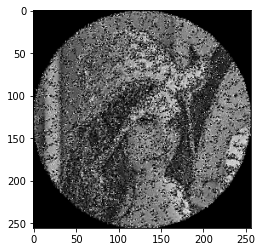

In [30]:
import matplotlib.pyplot as plt
import numpy as np


def img_to_png(path):
    fig = open(f"{path}.img", "rb")
    data = np.fromfile(fig, dtype=np.uint8)
    image = data.reshape((256, 256))
    plt.imshow(image, cmap="gray")
    plt.savefig(f"{path}.png")


output_file_cpu = "../content/lena_out"
output_file_nearest_neighbour = "../content/lena_nearest_neighbour"
output_file_bilinear = "../content/lena_bilinear"
output_file_bicubic = "../content/lena_bicubic"

img_to_png(output_file_cpu)
img_to_png(output_file_nearest_neighbour)
img_to_png(output_file_bilinear)
img_to_png(output_file_bicubic)